<a href="https://colab.research.google.com/github/nadya-soto/ConnectX_AI_Agents/blob/main/Dynamic_Programming_in_FrozenLake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#remove " > /dev/null 2>&1" to see what is being installed
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python3-opengl ffmpeg --fix-missing > /dev/null 2>&1
!pip install gym.wrappers > /dev/null 2>&1
!pip install gym[toy_text] > /dev/null 2>&1 # https://www.gymlibrary.dev/environments/toy_text/

In [ ]:
!pip install pygame

#### General libraries

In [ ]:
import gym
import numpy as np # to work with mathematical formulae
import time # to reduce the speed of simulations
import random # to randomly generate data
import matplotlib.pyplot as plt # to plot

# Libraries needed to create the virtual display and record the video
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import glob
import io
import base64
import pygame
from IPython.display import HTML, clear_output # Used to clear the ouput of a Jupyter cell.

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
pygame.init()
pygame.display.set_mode((1400, 900)) # change to the real resolution

<Surface(1400x900x32 SW)>

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video')#, force=True)
  return env

##### Utilities

The following functions can be useful to run the agents that you will create, as well as display the results in the notebook.

In [ ]:
## The following function will be use to evaluate the different policies.
# The environment env will define what type of grid we will use
# Agent will be defined according different policies

def run_agent(env, agent):
    state = env.reset()
    time_step = 0
    total_reward = 0
    max_iter = 100
    reward = 0;
    done = False
    while not done:
        env.render()    # this code displays the agent state and action
        time_step += 1
        action = agent.act(state);   #  we will need to define function policy(state)
        state, reward, done, info = env.step(action)  # step is defined into the environment, and it provides the new state, the reward obtained, and whether we finished or not
        total_reward += reward

        if time_step > max_iter:
          done = True
    print("Total reward:", total_reward)
    env.close()
    show_video()


In [ ]:
#This function will take an array and turn it into the grid format, and then plot the value function with a colourmap

def plot_values(VF, dimensions= (5,5), name = None):
# reshape value function according to the size of the grid (rows and columns)
    VF_grid = np.reshape(VF, dimensions)

# plot the state-value function
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.imshow(VF_grid, cmap='cool')
    fig.colorbar(im, ax=ax)   #  colourbar to indicate which is higher and lower
    if name == 'Policy':
            plt.title(name)
            plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    else:
      for (j,i),label in np.ndenumerate(VF_grid):
        ax.text(i, j, np.round(label, 2), ha='center', va='center', fontsize=14)
      plt.title(name+'-Value Function')

    plt.show()

We can try some examples for the function plot_values, so you can have an idea what it does

In [ ]:
Q = [1,3,4,6,20,4,1,5]
Q = np.array(Q)
V= 2*np.round(np.random.random_sample((16,)),2)+3

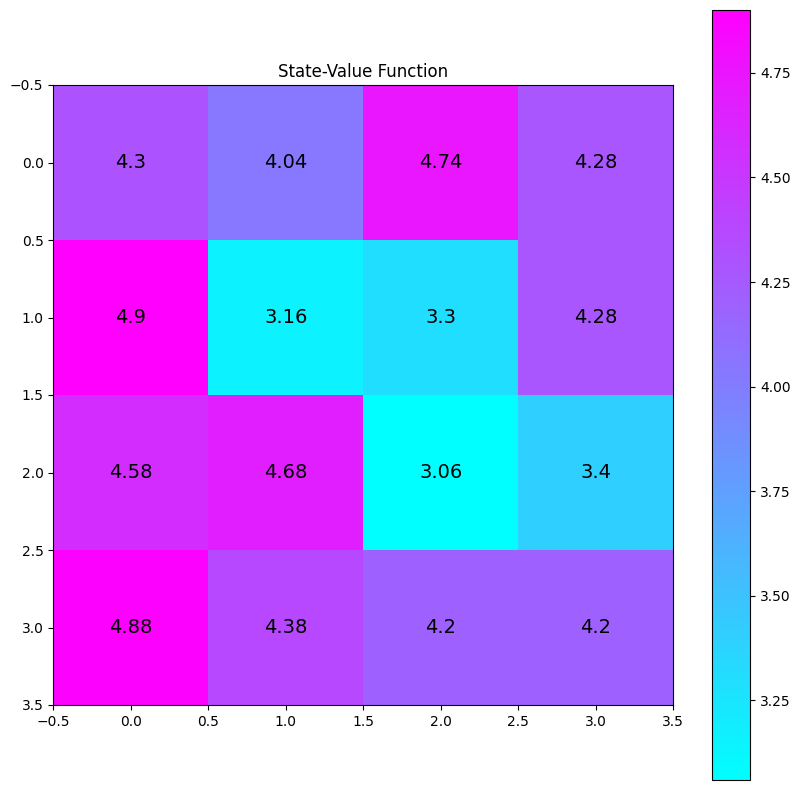

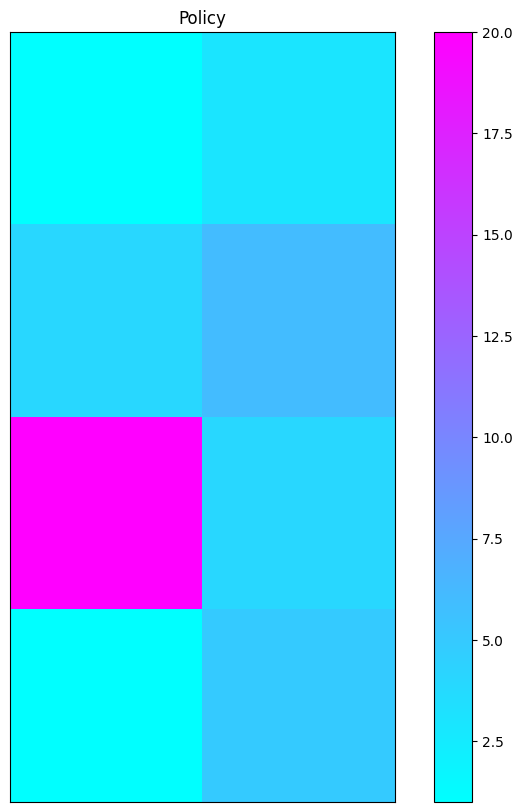

In [ ]:
plot_values(V,dimensions=(4,4), name='State')
plot_values(Q, dimensions=(4,2), name='Policy')

## Math functions in Numpy

[maths functions](https://numpy.org/doc/stable/reference/routines.math.html): In here you can find several useful mathematical functions that can be used in this notebook.

For example:
* [max](https://numpy.org/doc/stable/reference/generated/numpy.amax.html)

* [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)

* [abs](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html)


***
### Key variables in RL and OpenAI Gym

For this assignment we will explore two variants of the `FrozenLake` environment which contains a few cells with holes that once the agent step on it, it drowns and the episode finishes. We will give more details once we start working with them. In the meantime a few reminders on OpenAI Gym variables.

* __Agent__: The learner and decision maker. This is a class you should create.
* __Environment__:  What the agent interacts with. This is the variable `env` in `env = wrap_env(gym.make(version of frozenlake))`. In FrozenLake, a particularly important variable is `env.P`, which contains the Markov process model of the system. This variable encodes the state transition probabilities, rewards, and other information. The function `wrap_env()` allows to capture videos of the environment.
* __State__: A state $s \in \mathcal{S}$ is a representation of the environments current state.
* __Action__: The agent can take actions $a \in \mathcal{A}$ in order to change the state of the environment. It is an element of `env.action_space`.
* __Policy__: Rules for how the agent chooses the next action given the current state, $\pi(a|s)$ is the probability of choosing action `a` given that agent is currently in state `s`.
* __Reward__: An immediate reward $R(s,a)$ that the agent gets for taking action $a$ in state $s$. A reward depends on a state and action, so it can only be obtain through the `step` function, which in turn updates the environments state.



# Dynamic Programming



## FrozenLake 5x5 with 'bridge'.

* `S`: start point
* `G`: goal
* `F`: frozen floor (agent can walk over it)
* `H`: hole  (if agent steps on it, it sinks)



In [ ]:
FL_5x5_bridge=["SFHFF", "FHHHF", "FFFFG", "FHHHF", "FFHFF"]

In [ ]:
# Load environment
env = wrap_env(gym.make('FrozenLake-v1', desc=FL_5x5_bridge, is_slippery=False))
state = env.reset()
new_step_api=True # can be deleted, but in this case the library asks for this
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env.action_space)

Initial state: 0
State space: Discrete(25)
Action space: Discrete(4)


In [ ]:
new_state, reward, done, info = env.step(1) # Take action 1 (Down)
print("New state:", new_state)
print("Reward:", reward)
print("Done:", done)

New state: 5
Reward: 0.0
Done: False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
env.step(2)

(6, 0.0, True, {'prob': 1.0, 'TimeLimit.truncated': False})

__State space__: We see that the state space contains 25 discrete states. In this case each state corresponds to a position of the agent (5x5=25 possibilities).  

State *0* is the starting point **S**, and state *14* is the goal **G**.

__Action space__: The 4 discrete actions corresponds to: 0 - Left, 1 - Down, 2 - Right, 3 - Up.

Let us consider an agent that uses a random policy: chooses at random among their actions with `env.action_space.sample()`.

In [ ]:
state = env.reset()
iterations = 0
max_iter = 100
total_reward = 0
while not done:

    env.render()
    iterations += 1
    #your agent goes here
    action = env.action_space.sample()
    # action_space.sample() selects at random one action from the action space: {0,1,2,3}
    next_state, reward, done, info = env.step(action)
    total_reward += reward


    if iterations > max_iter:
      done = True

print("Total reward:", total_reward)
env.close()
show_video()

Total reward: 0.0


We define now a uniform random agent (that does not learn, only acts)

In [ ]:
# This random agent chooses actions uniformly at random (each action is selected with probability 1/(number of actions))
class RandomAgent(object):
    def __init__(self, env):
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        self.policy = np.ones((self.nS,self.nA))/self.nA #uniform distribution per state. Note how this table is organized: nS rows, nA columns

    def act(self, state):
        # IMPORTANT: here is where we define how the probability table 'policy' is interpreted
        action = np.random.choice(self.nA, p=self.policy[state])
        return action # a uniform random action per each state


In [ ]:
nA = env.action_space.n
nS = env.observation_space.n
agent_uniform = RandomAgent(env) #an instantiation of an agent of the class RandomAgent


In [ ]:
agent_uniform.policy[24] #policy at state s=0, starting point

array([0.25, 0.25, 0.25, 0.25])

What we see is that each row corresponds to a given state: `s=0` corresponds to `row 0` of the table. The action probabilities at a state `s` are given by `agent_uniform.policy[s]`.<br>
Simlarly, each column corresponds to a particular action `a`. The probability that action `a` is taken at state `s` is then given by `agent_uniform.policy[s][a]`.<br>
Mathematically, we then have that ${\pi}(A = a\,| S = s) =$ `agent_uniform.policy[s][a]`.

Let us see how it performs (try it a couple of times and see what typical total rewards are obtained).

In [ ]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((800, 600)) # change to the real resolution
run_agent(env, agent_uniform)

Total reward: 0.0


*Remark*: notice that in this grid we can easily spot the optimal policy, but a random agent struggles to find it.

In [ ]:
gamma =0.9 # default value, you can change it as you wish

# 1.1: Bellman Equation.

The following functions will help you to write the Bellman Equation for $v_{\pi}$ in a iterative way.

**the task here is to write down the respective pseudo code for each function, or alternatively, the equations or backup diagrams associated.

In [ ]:
def Bellman_update(env, policy, state_function, gamma=0.9):
  nS = env.observation_space.n
  nA = env.action_space.n
  V = state_function

  for s in range(nS):
    new_v = V[s]
    for a, action_proba in enumerate(policy[s]):
      for prob, next_state, reward, done in env.P[s][a]:
        new_v += action_proba * prob * (reward + gamma * V[next_state])

    V[s] = new_v
  return V

** Algorithm: Bellman Update for Estimating v_pi under a Given Policy pi**

- `env`: Environment in which the agent is interacting.
- `policy`: Policy being evaluated, probabilities of taking each action in each state.
- `state_function`: State value function ( V ) being updated.
- `gamma`: Indicates how much we value future rewards compared to immediate rewards.

Initialisation: V ( s ) arbitrarily initialized for all s in S. gamma: Discount factor.

Procedure Bellman_update(env, policy, state_function, gamma=0.9):

    nS = env.observation_space.n          (Number of states in the environment)
    nA = env.action_space.n               (Number of actions in the environment)
    V = state_function                    (Current state value function)

    For each state s in S do
        new_v = V[s]                      (Initialize the new value of V[s] with the current value)

        For each action a in A(s) do
            action_proba = policy[s][a]   (Probability of taking action a in state s)

            For each transition (prob, next_state, reward, done) in env.P[s][a] do  (Iterate over all possible transitions
                                                                                     from state s with action)
                new_v += action_proba * prob * (reward + gamma * V[next_state])

        V[s] = new_v                       (Update the state value for state s with the new value)
        
    Return V                               (Return the updated state value function)



The function `Bellman_update` implements the Bellman update to iteratively estimate the state value function ( V_pi ) under a given policy (pi) :

1. Initializes the state value function ( V ) with the current state value function.

2. Iterates over each state ( s ) in the observation space.

3. For each state ( s ), calculates the new value ( V(s) ) using the Bellman equation for the state value function:

   V(s) = sum_a [pi(a|s)] sum_(s', r) [ p(s', r|s, a)[r + gamma V(s')]

   Where:
   - pi(a|s) is the probability of taking action ( a ) in state ( s ) according to the policy.
   - p(s', r|s, a) is the probability of transitioning to state ( s') and receiving reward ( r ) given the current state ( s ) and action ( a ).
   - ( gamma ) is the discount factor.

4. Updates the state value V(s) with the calculated new value.

5. Returns the updated state value function V.


An important remark is that `Bellman_update` returns a vector with number of coordinates equals to the number of states.

#  1.2: Policy Evaluation

The following function will compute the Iterative Policy Evaluation algorithm (*Algorithm 1* from Lecture-3-new-version: https://moodle.essex.ac.uk/pluginfile.php/2486192/mod_resource/content/2/lecture-3-new.pdf). **Your task is to complete the following function where it says `# YOUR CODE HERE`**

In [ ]:
def policy_evaluation(env, agent, old_value, theta= 1e-6):
    # old_value takes the role of the initial values for V(s) in the algorithm 1 from lecture 3.
    current_policy = agent.policy #Input
    new_value = old_value #initialisation
    delta = theta +1#initialisation
    max_iter = 150

    # YOUR CODE HERE (you need to define how new_value is computed).
    # You can use the function from Task 1.1
    while delta > theta and max_iter > 0:
        delta = 0
        new_value = Bellman_update(env, current_policy, new_value)

        # Max
        for s in range(len(old_value)):
            delta = max(delta, abs(old_value[s] - new_value[s]))

        # Update
        old_value = new_value.copy()
        max_iter -= 1

    return new_value

In [ ]:
#policy_evaluation(env_bridge, agent_bridge_1, value_function_0)


array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ,
       1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0.9])

#  1.3: Policy Improvement


The following function will compute a *Policy Improvement* over the current policy $\pi$.

**the task is to write that function.** HINT: you can use the function from **Task 1.1** to create the new policy. Remember that from the Lectures (See equations (4.6) to (4.8)), you can create a new policy using the `q(s,a)` values, comparing them against the state-value functions `v(s)` (that you obtained in Task 1.2).

In [ ]:
def policy_improvement(env, agent, value_function):
    current_policy = agent.policy #input
    new_policy = current_policy # initialisation
    ##### YOUR CODE HERE: For each state, s, check if current_policy, provides the optimal action, a.
    # if not, then modify your new_policy greedily, assigning new_policy[s,a]=1, and the other coordinates = 0
    for state in range(nS):
      # Calculate the q-values for all possible actions in the current state
      q_values = [sum(prob * (reward + gamma * value_function[next_state]) for prob, next_state, reward, _ in env.P[state][action]) for action in range(nA)]

      best_action = np.argmax(q_values)
      new_policy[state] = np.eye(nA)[best_action]
    return new_policy





In [ ]:
#policy_improvement(env_bridge, agent_bridge_1, value_function_0)


array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])


Policy Iteration Algorithm

The following function should combined both functions from  ** 1.2** and ** 1.3** to create a Policy Iteration Algorithm

**the task is to write that function**. It should return both the Optimal Policy and the Optimal State Value Function.

You can do this in more than one cell. For example use the following function to compute the optimal state value $v$, use that to obtain the optimal action value  $q$, and with that define the optimal policy. But you also can do it in one step.

In [ ]:
'''
def policy_iteration(env, agent, value_function, MaxIter=200, theta=1e-6):
    optimal_value_function = value_function.copy()  # Inicialización de la función de valor óptima
    optimal_policy = agent.policy.copy()  # Inicialización de la política óptima

    for i in range(MaxIter):
        optimal_value_function = policy_evaluation(env, agent, optimal_value_function, theta)        # Evaluación
        new_policy = policy_improvement(env, agent, optimal_value_function)         # Mejor

        if np.array_equal(new_policy, optimal_policy): # Verificar convergencia

        # Actualizar
        optimal_policy = new_policy

    return optimal_policy, optimal_value_function
'''

' \ndef policy_iteration(env, agent, value_function, MaxIter=200, theta=1e-6):\n    optimal_value_function = value_function.copy()  # Inicialización de la función de valor óptima\n    optimal_policy = agent.policy.copy()  # Inicialización de la política óptima\n\n    for i in range(MaxIter):\n        optimal_value_function = policy_evaluation(env, agent, optimal_value_function, theta)        # Evaluación\n        new_policy = policy_improvement(env, agent, optimal_value_function)         # Mejor\n\n        if np.array_equal(new_policy, optimal_policy): # Verificar convergencia\n\n        # Actualizar\n        optimal_policy = new_policy\n\n    return optimal_policy, optimal_value_function\n'

In [ ]:
def policy_iteration(env, agent, value_function, MaxIter=200, theta=1e-6):
    # Run until no changes (tol) or until we run out of time (MaxIter)
    optimal_value_function = value_function   # Initialization
    optimal_policy = agent.policy  # Initialization

    for _ in range(MaxIter):
        # Policy Evaluation
        while True:
            delta = 0
            for s in range(env.observation_space.n):
                v = optimal_value_function[s]
                new_v = 0
                for a, action_prob in enumerate(optimal_policy[s]):
                    for prob, next_state, reward, _ in env.P[s][a]:
                        new_v += action_prob * prob * (reward + gamma * optimal_value_function[next_state])
                optimal_value_function[s] = new_v
                delta = max(delta, abs(v - optimal_value_function[s]))
            if delta < theta:
                break

        # Policy Improvement
        policy_stable = True
        for s in range(env.observation_space.n):
            old_action = np.argmax(optimal_policy[s])
            action_values = np.zeros(env.action_space.n)
            for a in range(env.action_space.n):
                for prob, next_state, reward, _ in env.P[s][a]:
                    action_values[a] += prob * (reward + gamma * optimal_value_function[next_state])
            best_action = np.argmax(action_values)
            optimal_policy[s] = np.eye(env.action_space.n)[best_action]
            if old_action != best_action:
                policy_stable = False

        if policy_stable:
            break

    return optimal_policy, optimal_value_function


In [ ]:
#policy_iteration(env_bridge, agent_bridge_1, value_function_0, MaxIter=10, theta=1e-6)

(array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([1.e-05, 1.e-06, 0.e+00, 1.e-02, 1.e-01, 1.e-04, 0.e+00, 0.e+00,
        0.e+00, 1.e+00, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 0.e+00, 1.e-04,
        0.e+00, 0.e+00, 0.e+00, 1.e+00, 1.e-05, 1.e-06, 0.e+00, 1.e-02,
        1.e-01]))

# 1.5: Value Iteration Algorithm
Similar to the previous point the following function is the `Value Iteration Algorithm`.

**the task is to create that function**. The procedure should be similar to ** 1.4** but you merged a couple of steps (sweeps) into one.  You should provide the Optimal State Function and the respective Optimal Policy.



In [ ]:
def value_iteration(env, agent, value_function, MaxIter=200, theta=1e-6):
    optimal_policy = agent.policy  # Initialization of the optimal policy
    optimal_value_function = value_function  # Initialization of the optimal value function
    old_value = value_function  # Initialisation

    delta = theta + 1

    for i in range(MaxIter):
        delta = 0
        optimal_value_function = policy_evaluation(env, agent, optimal_value_function, theta)       # Evaluation of the current policy

        new_policy = policy_improvement(env, agent, optimal_value_function) # Policy Improvement

        delta = np.sum(np.abs(new_policy - optimal_policy)) # Calculate the maximum change in polic

        if delta < theta:   # Check for convergence
            break

        optimal_policy = new_policy  # Update

    return optimal_policy, optimal_value_function



---



Now is time to test them on the environment.




In [ ]:
# Load environment
env_bridge = wrap_env(gym.make('FrozenLake-v1', desc=FL_5x5_bridge, is_slippery=False))
state = env_bridge.reset()
new_step_api=True # can be deleted, but in this case the library asks for this
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_bridge.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env_bridge.action_space)

Initial state: 0
State space: Discrete(25)
Action space: Discrete(4)


In [ ]:
nS_bridge = env_bridge.observation_space.n
nA_bridge = env_bridge.action_space.n
agent_bridge_1 = RandomAgent(env_bridge) #an instantiation of an agent of the class RandomAgent


Improve `agent_bridge` policy using POLICY iteration algorithm (algorithm from Task 1.4) and run the improved agent again (you can do many runs to observe the improvement step by step).

Return the `optimal_value_function` and `optimal_policy` of this improved agent.

In [ ]:
value_function_0 = np.zeros(nS_bridge)
gamma=.1
optimal_policy, optimal_value_function = policy_iteration(env_bridge, agent_bridge_1, value_function_0, MaxIter=1000, theta=1e-6)


Run the following cell to display the optimal values of `agent_bridge_1` improved policy.

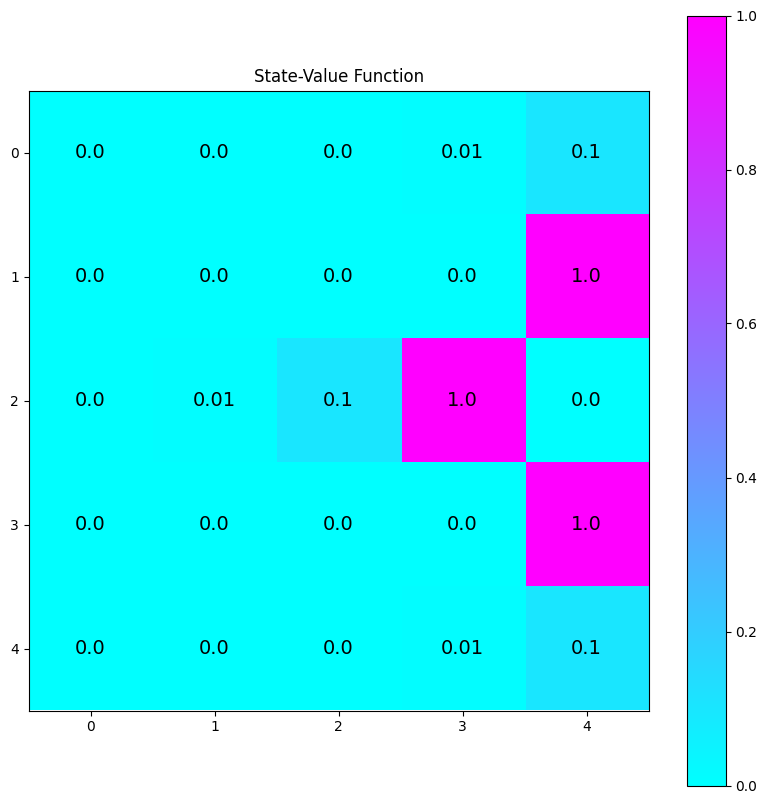

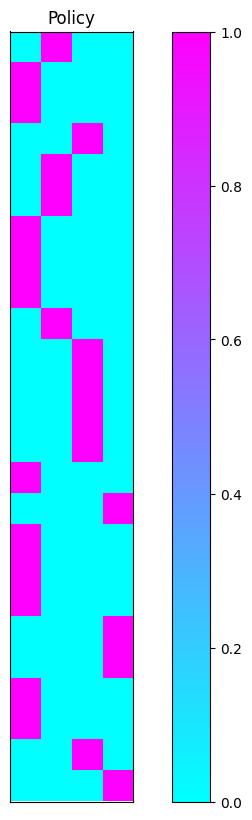

In [ ]:
plot_values(optimal_value_function, dimensions=(5,5), name='State')
plot_values(optimal_policy, dimensions=(nS_bridge, nA_bridge), name = 'Policy')

If everything is correctly implemented, then the following code should run the `agent_bridge_1` that is able to find the `goal`.

In [ ]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((800, 600)) # change to the real resolution
run_agent(env_bridge, agent_bridge_1)

Total reward: 1.0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
'''#NOTE: you might need to run this cell twice if it gives an error associated to video.
pygame.init()
pygame.display.set_mode((800, 600)) # change to the real resolution
run_agent(env_bridge, agent_bridge_1)
'''

Total reward: 1.0


Testing with GAMMA = 0.1


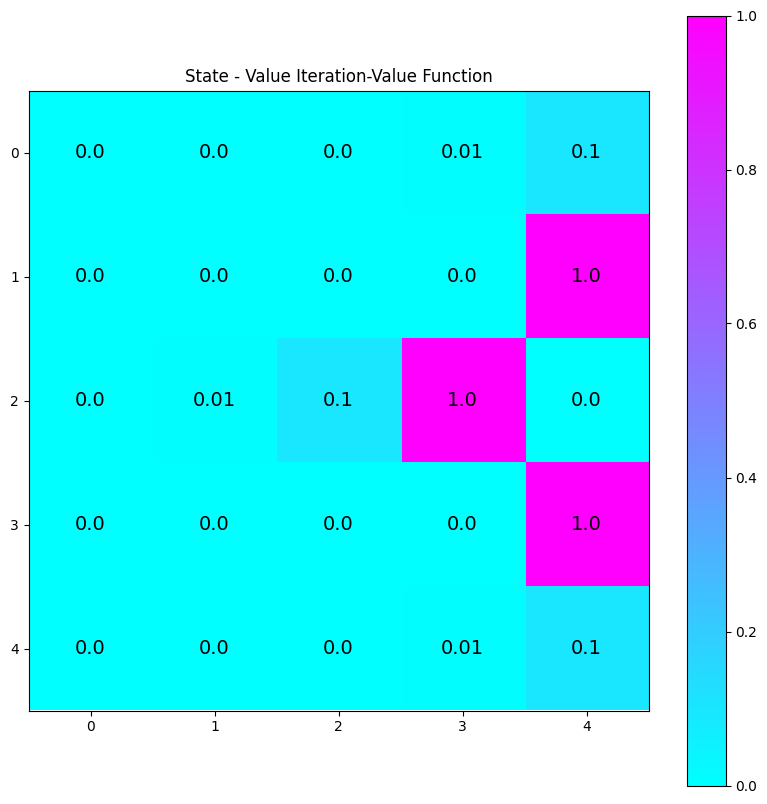

Total reward: 1.0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Testing with GAMMA = 0.5


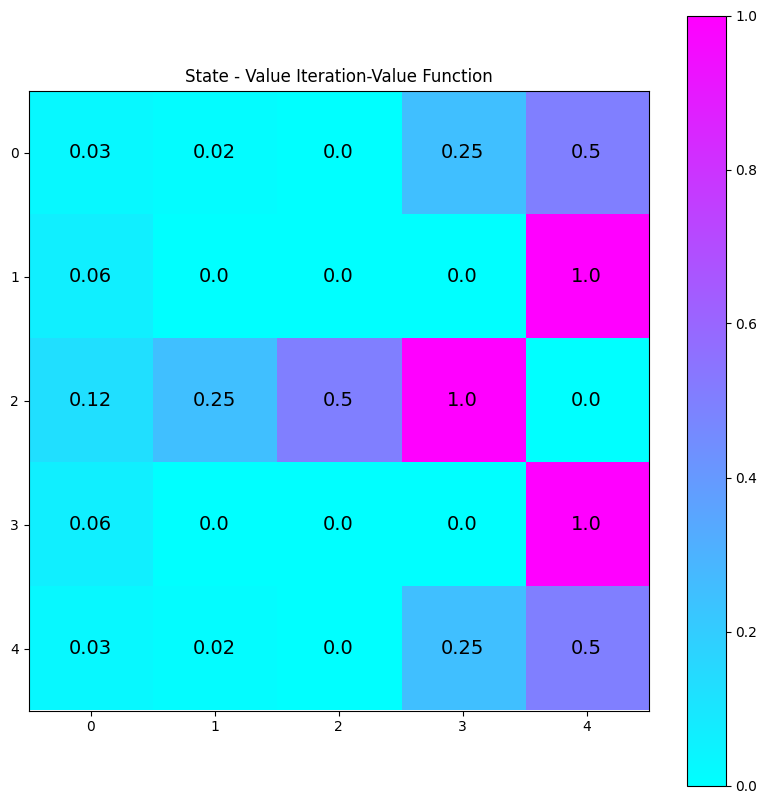

Total reward: 1.0


Testing with GAMMA = 0.9


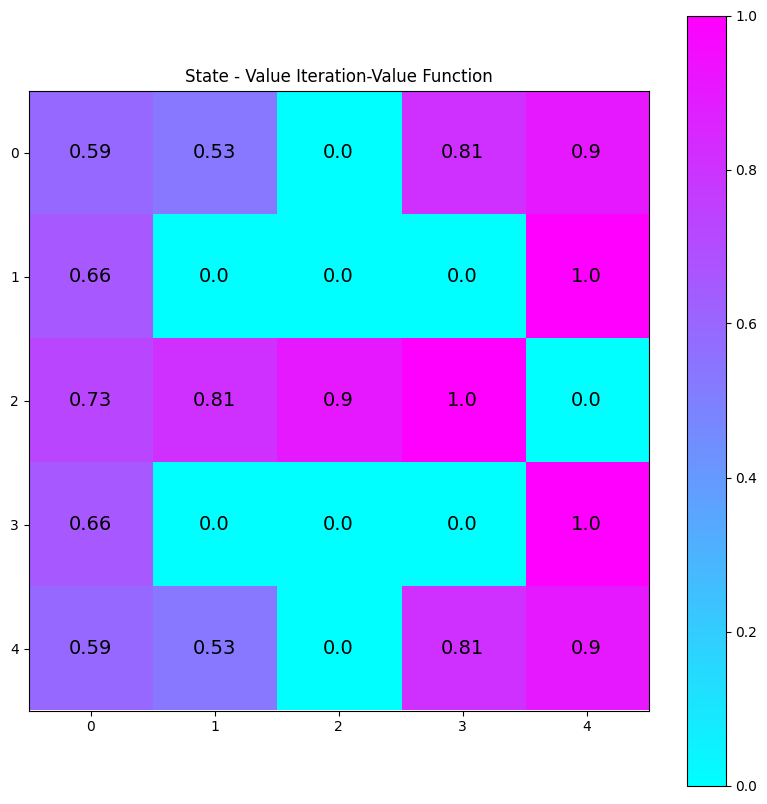

Total reward: 1.0


In [ ]:
# Try different values of GAMMA
gammas = [0.1, 0.5, 0.9]

for gamma in gammas:
  print(f"Testing with GAMMA = {gamma}")
  # Value Iteration
  optimal_policy_vi, optimal_value_function_vi = value_iteration(env_bridge, agent_bridge_1, value_function_0)
  # Policy Iteration
  optimal_policy_pi, optimal_value_function_pi = policy_iteration(env_bridge, agent_bridge_1, value_function_0)

  # Visualize the results
  plot_values(optimal_value_function_vi, dimensions=(5, 5), name='State - Value Iteration')

  #NOTE: you might need to run this cell twice if it gives an error associated to video.

  pygame.init()
  pygame.display.set_mode((800, 600)) # change to the real resolution
  run_agent(env_bridge, agent_bridge_1)



##  1.6.2.

Create a different agent, `agent_bridge_2` initialised as an uniform random agent, and then improve its policy using VALUE iteration algoritm (from Task 1.5).

Run the new agent and return its optimal value function and optimal policy.

In [ ]:
agent_bridge_2 = RandomAgent(env_bridge)


In [ ]:
value_function_0 = np.zeros(nS_bridge)
optimal_policy_2, optimal_value_function_2 = value_iteration(env_bridge, agent_bridge_2, value_function_0, MaxIter=1000, theta=1e-6)

Run the following cell to display the optimal values of `agent_bridge_2` improved policy.

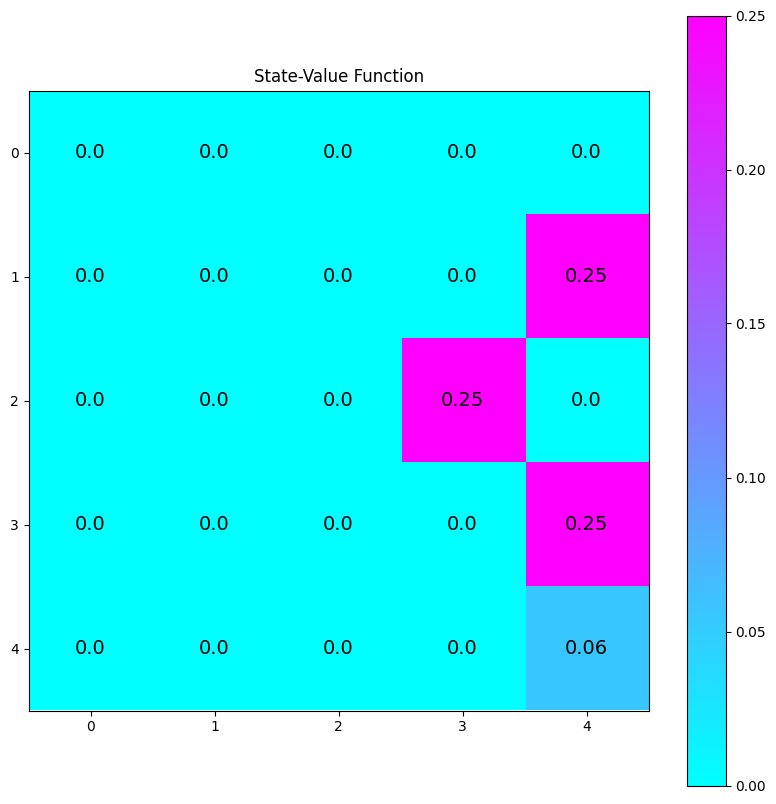

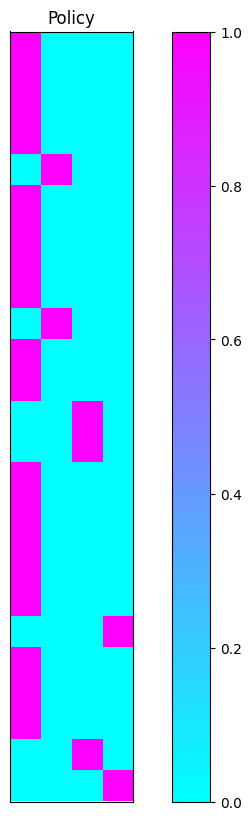

In [ ]:
plot_values(optimal_value_function_2, dimensions=(5,5), name='State')
plot_values(optimal_policy_2, dimensions=(nS_bridge, nA_bridge), name = 'Policy')

If everything is correctly implemented, then the following code should run the `agent_bridge_2` that is able to find the `goal`.

In [ ]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((800, 600)) # change to the real resolution
run_agent(env_bridge, agent_bridge_2)

Total reward: 0.0


**Question** Can you measure which method find the optimal policy faster? (if any)

In [ ]:
# Measure the time taken by policy iteration
import time
start_time = time.time()
optimal_policy_pi, optimal_value_function_pi = policy_iteration(env, agent_bridge_1, value_function_0)
policy_iteration_time = time.time() - start_time

# Measure the time taken by value iteration
start_time = time.time()
optimal_policy_vi, optimal_value_function_vi = value_iteration(env, agent_bridge_1, value_function_0)
value_iteration_time = time.time() - start_time

num_iterations = 0

# Compare the computational time
print("Policy Iteration - Time Taken:", policy_iteration_time)
print("Value Iteration - Time Taken:", value_iteration_time)

Policy Iteration - Time Taken: 0.15093111991882324
Value Iteration - Time Taken: 0.0026814937591552734


    Policy Iteration took approximately 0.151 seconds.
    Value Iteration took approximately 0.003 seconds.

Comparing the execution times, we can conclude that Value Iteration finds the optimal policy much faster than Policy Iteration in this specific case.

In [ ]:
def run_agent_with_iterations(env, agent):
    global num_iterations
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
        num_iterations += 1
    return num_iterations


In [ ]:
num_iterations_ag1 = run_agent_with_iterations(env_bridge, agent_bridge_1)
num_iterations_ag2 = run_agent_with_iterations(env_bridge, agent_bridge_2)

# Print the Number of Iterations
print("Number of iterations of agent1:", num_iterations_ag1)
print("Number of iterations of agent2:", num_iterations_ag2)


Number of iterations of agent1: 300
Number of iterations of agent2: 400


# Larger Frozen Lake environment

In [ ]:
FL_15x9=["FFHHFHFFFGFFHHF","FFFFFFFFHFHFFFF","FHFFHHHFFFHHFFF","FFFFHFFFFFFHFFF","FGFFHFFSFFFHGFH","HHFFFFHFHFFFFFH","FFFHFFFFFFFFFFH","HHFFFFFHFFFFHFF","FFHHFFFFGHHFFFF"]

In [ ]:
# Load environment
gamma=0.9
env_large_FL = wrap_env(gym.make('FrozenLake-v1', desc=FL_15x9,is_slippery=False))
state = env_large_FL.reset()
new_step_api=True # can be deleted, but in this case the library asks for this
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_large_FL.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env_large_FL.action_space)

Initial state: 67
State space: Discrete(135)
Action space: Discrete(4)


In [ ]:
agent_large_FL = RandomAgent(env_large_FL)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pygame.init()
pygame.display.set_mode((1400, 900)) # change to the real resolution
run_agent(env_large_FL, agent_large_FL)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Total reward: 0.0


In [ ]:
done = False
state = env_large_FL.reset()
iterations = 0
max_iter = 100
total_reward = 0
while not done:
  env_large_FL.render()
  iterations += 1
  #your agent goes here
  action = env_large_FL.action_space.sample()
  # action_space.sample() selects at random one action from the action space: {0,1,2,3}
  next_state, reward, done, info = env_large_FL.step(action)
  total_reward += reward


  if iterations > max_iter:
    done = True

print("Total reward:", total_reward)
env_large_FL.close()
show_video()

Total reward: 0.0


# 1.7 Testing Frozen Lake Large Environment

Similar to the case of GridWorld, **your task improve the policy of Agent_Large_FL_2 and Agent_Large_FL_3 using  Policy Iteration and Value Iteration, respectively**.

Repeat the same procedure as in Tasks 1.6.1 (evaluate policy iteration) and 1.6.2 (evaluate value iteration)

Play around with the parameters (GAMMA, MaxIter) to see if they have any effect on avoiding the death of your agent.

In [ ]:
# Load environment
gamma=0.9
env_large_FL = wrap_env(gym.make('FrozenLake-v1', desc=FL_15x9,is_slippery=False))
state = env_large_FL.reset()
new_step_api=True # can be deleted, but in this case the library asks for this
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_large_FL.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env_large_FL.action_space)

Initial state: 67
State space: Discrete(135)
Action space: Discrete(4)


In [ ]:
## YOUR CODE HERE

# Improve policy using POLICY ITERATION
# Plot new optimal policy
# run new optimal agent in the large_FL environment

In [ ]:
nS_bridge_L = env_large_FL.observation_space.n
nA_bridge_L = env_large_FL.action_space.n
agent_Large_FL_2 = RandomAgent(env_large_FL)



In [ ]:
value_function_0 = np.zeros(nS_bridge_L)
optimal_policy, optimal_value_function = policy_iteration(env_large_FL, agent_Large_FL_2, value_function_0, MaxIter=1000, theta=1e-6)

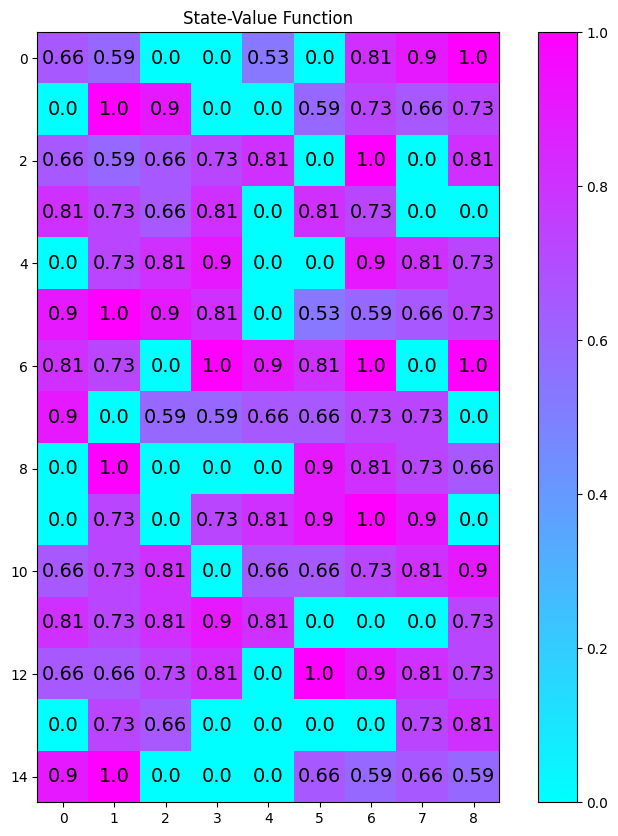

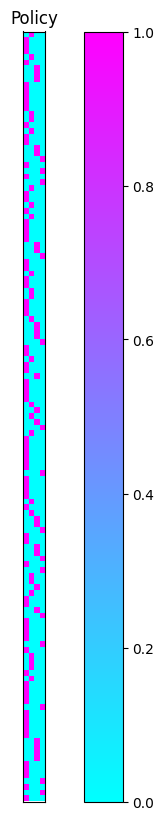

In [ ]:
plot_values(optimal_value_function, dimensions=(15,9), name='State')
plot_values(optimal_policy, dimensions=(nS_bridge_L, nA_bridge_L), name = 'Policy')

In [ ]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((800, 600)) # change to the real resolution
run_agent(env_large_FL, agent_Large_FL_2)

Total reward: 1.0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Retrieve Agent3's optimal policy and value function and plot them using the below cell.

In [ ]:
# Load environment
gamma=.9
env_large_FL2 = wrap_env(gym.make('FrozenLake-v1', desc=FL_15x9,is_slippery=False))
state = env_large_FL2.reset()
new_step_api=True # can be deleted, but in this case the library asks for this
print('Initial state:', state) #reminder: python starts counting from 0
print("State space:", env_large_FL2.observation_space) # observations and states will be the same for us in this lab
print("Action space:", env_large_FL2.action_space)

Initial state: 67
State space: Discrete(135)
Action space: Discrete(4)


In [ ]:
nS_bridge_L = env_large_FL2.observation_space.n
nA_bridge_L = env_large_FL2.action_space.n
agent_Large_FL_3 = RandomAgent(env_large_FL2)
## YOUR CODE HERE

# Improve policy using Value ITERATION
# Plot new optimal policy
# run new optimal agent in the large_FL environment


In [ ]:
value_function_0 = np.zeros(nS_bridge_L)
optimal_policy2, optimal_value_function2 = value_iteration(env_large_FL2, agent_Large_FL_3, value_function_0, MaxIter=10000, theta=10e-4)

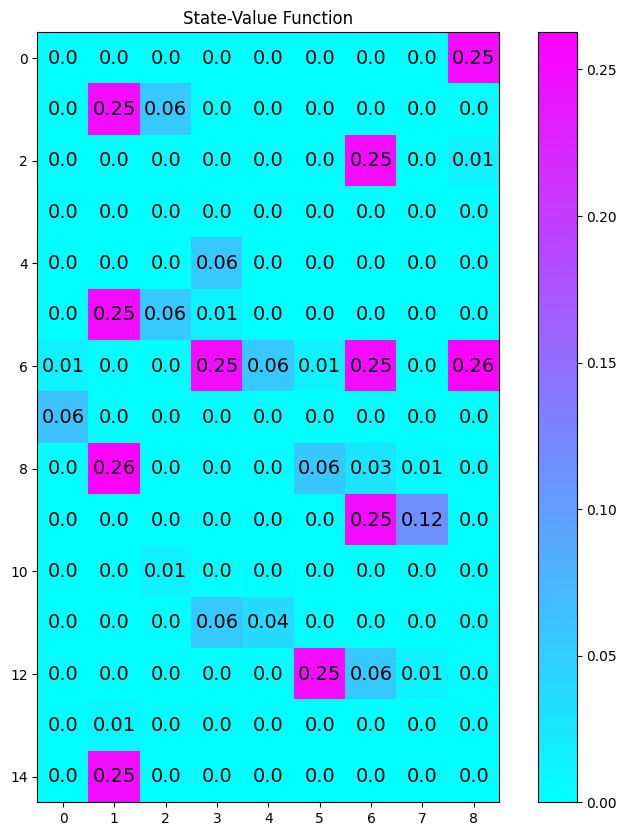

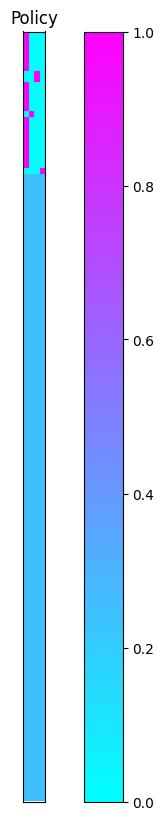

In [ ]:
plot_values(optimal_value_function2, dimensions=(15,9), name='State')
plot_values(optimal_policy2, dimensions=(nS_bridge_L, nA_bridge_L), name = 'Policy')

In [ ]:
#NOTE: you might need to run this cell twice if it gives an error associated to video.

pygame.init()
pygame.display.set_mode((800, 600)) # change to the real resolution
run_agent(env_large_FL2, agent_Large_FL_3)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Total reward: 1.0


With MaxIter=1000 and theta=1e-6 it wasn't successful, but when changing theta and the iterations, it worked with MaxIter=10000, theta=10e-4.
